In [1]:
%pylab inline 
import geopandas as gpd 
import rasterio as rio 
import rasterio.mask as mask
import rasterio.features
import rasterio.plot as riop 

import os
from gis_functions import clip_raster_to_geometry, clip_shp_to_geometry
from sinkhole_functions import calc_karst_fraction

Populating the interactive namespace from numpy and matplotlib


In [17]:
datadir = '/home/mcoving/github/sinkhole_analysis/'
basedir = '/home/mcoving/Dropbox/sync/projects/Dolines/'
hu10 = gpd.read_file(basedir+'USGS-NHD-DEMs/GDB/NHDPLUS_H_0511_HU4_GDB.gdb', layer='WBDHU10')
hu12 = gpd.read_file(basedir+'USGS-NHD-DEMs/GDB/NHDPLUS_H_0511_HU4_GDB.gdb', layer='WBDHU12')

In [19]:
hu10

,TNMID,MetaSourceID,SourceDataDesc,SourceOriginator,SourceFeatureID,LoadDate,AreaSqKm,AreaAcres,GNIS_ID,Name,States,HUC10,HUType,HUMod,Shape_Length,Shape_Area,geometry
0,{C0BEADD7-670A-4923-8F77-2CCA0225A393},None,None,None,None,2012-10-24T07:27:33+00:00,350.92,86714.39,None,Big Pitman Creek,KY,0511000105,S,None,1.173566,0.035702,"MULTIPOLYGON (((-85.49812 37.48341, -85.49797 ..."
1,{CDBDF48E-AD00-4103-BBCA-35329D380585},None,None,None,None,2012-10-24T07:27:33+00:00,657.91,162571.81,None,Park City-Barren River,KY,0511000207,S,None,2.055673,0.066621,"MULTIPOLYGON (((-86.00875 37.14358, -86.00811 ..."
2,{ABF10D7B-0FFF-4AAA-9BF0-9D4E807250B3},None,None,None,None,2012-10-24T07:27:33+00:00,264.02,65240.28,None,Muddy Creek,KY,0511000301,S,None,1.014763,0.026756,"MULTIPOLYGON (((-86.78137 37.22924, -86.78094 ..."
3,{5249BD1A-8138-4C99-AA27-40E9807A190A},None,None,None,None,2012-10-24T07:27:33+00:00,424.20,104821.63,None,Lewis Creek-Green River,KY,0511000305,S,None,1.625486,0.043134,"MULTIPOLYGON (((-87.13458 37.48513, -87.13337 ..."
4,{5E91DACF-AC00-4580-A74C-DB0AFCB616F4},None,None,None,None,2012-10-24T07:27:35+00:00,555.11,137170.74,None,Clifty Creek-Rough River,KY,0511000401,S,None,1.523220,0.056655,"MULTIPOLYGON (((-86.08137 37.78658, -86.07951 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,{8EB6BE5A-B166-4B2C-97CB-0CC0AF752847},None,None,None,None,2012-10-24T07:27:33+00:00,662.44,163691.40,None,Lower Nolin River,KY,0511000111,S,None,2.219203,0.067371,"MULTIPOLYGON (((-86.16071 37.48982, -86.15962 ..."
125,{6363FAE1-D438-434B-8327-5C2A15204381},None,None,None,None,2012-10-24T07:27:33+00:00,952.89,235464.06,None,Middle Nolin River,KY,0511000110,S,None,2.099163,0.097182,"MULTIPOLYGON (((-85.88296 37.75500, -85.88240 ..."
126,{CDBDF48E-AD00-4103-BBCA-35329D380585},None,None,None,None,2012-10-24T07:27:33+00:00,657.91,162571.81,None,Park City-Barren River,KY,0511000207,S,None,2.055673,0.066621,"MULTIPOLYGON (((-86.00875 37.14358, -86.00811 ..."
127,{E0B254EE-3758-4D6A-8861-3C1C4F3D256F},None,None,None,None,2012-10-24T07:27:33+00:00,470.13,116171.53,None,Beaverdam Creek-Green River,KY,0511000113,S,None,1.585322,0.047690,"MULTIPOLYGON (((-86.14790 37.26028, -86.14643 ..."


In [3]:
#Load Little Barren River HUC10
lbr = hu10[hu10.HUC10 == '0511000106']
lbr.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin Island

In [4]:
rasterdir = os.path.join(basedir,'USGS-NHD-DEMs/Rasters/HRNHDPlusRasters0511/')
rasterfile = 'elev_cm.tif'
img = clip_raster_to_geometry(rasterdir=rasterdir,
                              rasterfile=rasterfile,
                              geom_df=lbr,
                              clipname='HUC-0511000106-')

In [5]:
rasterfile = 'hydrodem.tif'
hyd_img = clip_raster_to_geometry(rasterdir=rasterdir,
                              rasterfile=rasterfile,
                              geom_df=lbr,
                              clipname='HUC-0511000106-')

In [6]:
rasterfile = 'fdr.tif'
fd_img = clip_raster_to_geometry(rasterdir=rasterdir,
                              rasterfile=rasterfile,
                              geom_df=lbr,
                              clipname='HUC-0511000106-')

In [8]:
imgsrc = rio.open(datadir+'HUC-0511000106-elev_cm.tif')

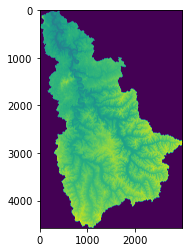

<AxesSubplot:>

In [9]:
riop.show(img)

In [10]:
sinks = clip_shp_to_geometry(clipname='HUC-0511000106-sinks-', 
                             shpdir=os.path.join(basedir, 'Kentucky','kysinks'),
                             shpfile='kentucky_sinkholes.shp',
                             geom_df=lbr,
                             outcrs=imgsrc.crs
                             )

In [32]:
sinks.crs

<Projected CRS: ESRI:102039>
Name: USA_Contiguous_Albers_Equal_Area_Conic_USGS_version
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [10]:
sinksfile = os.path.join(datadir,'HUC-0511000106-sinks-kentucky_sinkholes.shp')
wat = calc_karst_fraction(datadir=datadir,
                          demfile='HUC-0511000106-elev_cm.tif',
                          sinksfile=sinksfile)

./whitebox_tools --run="MeanFilter" --input='/home/mcoving/github/sinkhole_analysis/HUC-0511000106-elev_cm.tif' --output='/home/mcoving/github/sinkhole_analysis/HUC-0511000106-elev_cm-smoothed.tif' --filterx=5 --filtery=5

****************************
* Welcome to MeanFilter    *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Creating integral images: 0%
Creating integral images: 1%
Creating integral images: 2%
Creating integral images: 3%
Creating integral images: 4%
Creating integral images: 5%
Creating integral images: 6%
Creating integral images: 7%
Creating integral images: 8%
Creating integral images: 9%
Creating integral images: 10%
Creating integral images: 11%
Creating integral images: 12%
Creating integral images: 13%
Creating integral images: 14%
Creating integral images: 15%
Creating integral images: 16%
Creating integral images: 17%
Creating integral images: 18%
Creating integral images: 19%
Creating integral images: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Rasterizing 282 of 1186: 1066%
Rasterizing 282 of 1186: 1067%
Rasterizing 282 of 1186: 1068%
Rasterizing 282 of 1186: 1069%
Rasterizing 282 of 1186: 1070%
Rasterizing 282 of 1186: 1071%
Rasterizing 282 of 1186: 1072%
Rasterizing 282 of 1186: 1073%
Rasterizing 282 of 1186: 1074%
Rasterizing 282 of 1186: 1075%
Rasterizing 282 of 1186: 1076%
Rasterizing 282 of 1186: 1077%
Rasterizing 282 of 1186: 1078%
Rasterizing 282 of 1186: 1079%
Rasterizing 282 of 1186: 1080%
Rasterizing 282 of 1186: 1081%
Rasterizing 282 of 1186: 1082%
Rasterizing 282 of 1186: 1083%
Rasterizing 282 of 1186: 1084%
Rasterizing 282 of 1186: 1085%
Rasterizing 282 of 1186: 1086%
Rasterizing 282 of 1186: 1087%
Rasterizing 282 of 1186: 1088%
Rasterizing 282 of 1186: 1089%
Rasterizing 282 of 1186: 1090%
Rasterizing 282 of 1186: 1091%
Rasterizing 282 of 1186: 1092%
Rasterizing 282 of 1186: 1093%
Rasterizing 282 of 1186: 1094%
Rasterizing 282 of 1186: 1095%
Rasterizing 282 of 1186: 1096%
Rasterizing 282 of 1186: 1097%
Rasteriz

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Rasterizing 598 of 1186: 18450%
Rasterizing 598 of 1186: 18460%
Rasterizing 598 of 1186: 18470%
Rasterizing 598 of 1186: 18480%
Rasterizing 598 of 1186: 50%
Rasterizing 599 of 1186: 20422%
Rasterizing 599 of 1186: 20433%
Rasterizing 599 of 1186: 20444%
Rasterizing 599 of 1186: 20455%
Rasterizing 599 of 1186: 20466%
Rasterizing 599 of 1186: 20477%
Rasterizing 599 of 1186: 20488%
Rasterizing 599 of 1186: 20500%
Rasterizing 599 of 1186: 20511%
Rasterizing 599 of 1186: 50%
Rasterizing 600 of 1186: 16963%
Rasterizing 600 of 1186: 16972%
Rasterizing 600 of 1186: 16981%
Rasterizing 600 of 1186: 16990%
Rasterizing 600 of 1186: 17000%
Rasterizing 600 of 1186: 17009%
Rasterizing 600 of 1186: 17018%
Rasterizing 600 of 1186: 17027%
Rasterizing 600 of 1186: 17036%
Rasterizing 600 of 1186: 17045%
Rasterizing 600 of 1186: 17054%
Rasterizing 600 of 1186: 50%
Rasterizing 601 of 1186: 61333%
Rasterizing 601 of 1186: 61366%
Rasterizing 601 of 1186: 61400%
Rasterizing 601 of 1186: 50%
Rasterizing 602 of 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Rasterizing 895 of 1186: 9638%
Rasterizing 895 of 1186: 75%
Rasterizing 896 of 1186: 11245%
Rasterizing 896 of 1186: 11254%
Rasterizing 896 of 1186: 11263%
Rasterizing 896 of 1186: 11272%
Rasterizing 896 of 1186: 11281%
Rasterizing 896 of 1186: 11290%
Rasterizing 896 of 1186: 11300%
Rasterizing 896 of 1186: 11309%
Rasterizing 896 of 1186: 11318%
Rasterizing 896 of 1186: 11327%
Rasterizing 896 of 1186: 11336%
Rasterizing 896 of 1186: 75%
Rasterizing 897 of 1186: 5204%
Rasterizing 897 of 1186: 5208%
Rasterizing 897 of 1186: 5212%
Rasterizing 897 of 1186: 5216%
Rasterizing 897 of 1186: 5220%
Rasterizing 897 of 1186: 5225%
Rasterizing 897 of 1186: 5229%
Rasterizing 897 of 1186: 5233%
Rasterizing 897 of 1186: 5237%
Rasterizing 897 of 1186: 5241%
Rasterizing 897 of 1186: 5245%
Rasterizing 897 of 1186: 5250%
Rasterizing 897 of 1186: 5254%
Rasterizing 897 of 1186: 5258%
Rasterizing 897 of 1186: 5262%
Rasterizing 897 of 1186: 5266%
Rasterizing 897 of 1186: 5270%
Rasterizing 897 of 1186: 5275%
R

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



n karst draining pixels = 982537
n fluvial draining pixels = 12734889
percent karst = 0.07162692184379198


<AxesSubplot:>

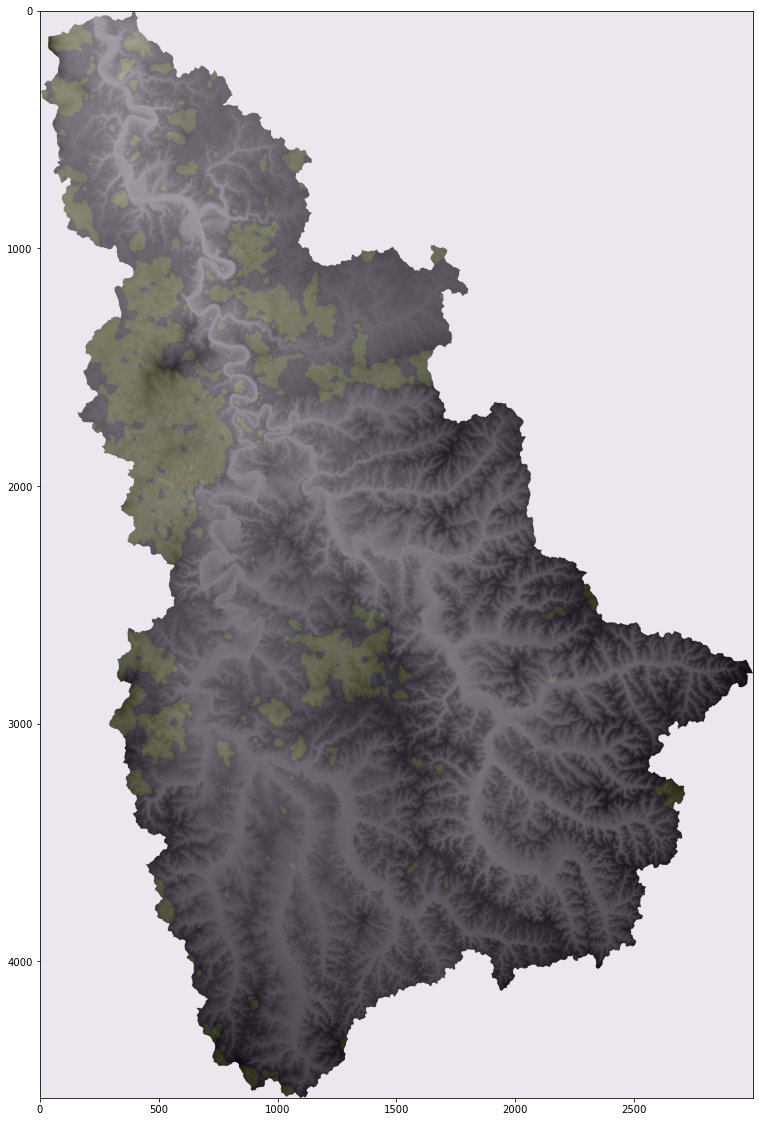

In [11]:
fig, ax = subplots(figsize=(20,20))
riop.show(img, ax=ax, cmap='Greys')
riop.show(wat, ax=ax, alpha=0.1)

Rasterizing using rasterio rather than whitebox

In [12]:
huc_sinks = gpd.read_file(datadir+'HUC-0511000106-sinks-kentucky_sinkholes.shp')
huc_sinks['ID'] = huc_sinks.index.values
huc_sinks

,ACRES,HECTARES,geometry,ID
0,1.893,0.766,"POLYGON ((928903.995 1597886.954, 928959.642 1...",0
1,2.394,0.969,"POLYGON ((928854.419 1598147.274, 928876.589 1...",1
2,2.597,1.051,"POLYGON ((928681.210 1597996.394, 928724.455 1...",2
3,8.983,3.636,"POLYGON ((929005.534 1598331.162, 929015.663 1...",3
4,10.040,4.063,"POLYGON ((928612.493 1598709.474, 928630.807 1...",4
...,...,...,...,...
1181,0.956,0.387,"POLYGON ((910664.361 1620259.576, 910682.522 1...",1181
1182,7.608,3.079,"POLYGON ((910558.868 1621309.267, 910559.572 1...",1182
1183,5.593,2.263,"POLYGON ((912590.271 1601812.196, 912586.457 1...",1183
1184,3.680,1.489,"POLYGON ((910079.759 1600534.964, 910099.645 1...",1184


In [13]:
sinks_list = huc_sinks[['geometry','ID']].values.tolist()

In [14]:
out_shape = imgsrc.shape
out_trans = imgsrc.transform
sinks_array = rasterio.features.rasterize(sinks_list,
                fill=0, out_shape= out_shape,
                transform = out_trans)

In [22]:
profile = imgsrc.profile
profile


{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 0.0, 'width': 2999, 'height': 4574, 'count': 1, 'crs': CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(10.0, 0.0, 902365.0,
       0.0, -10.0, 1631345.0), 'tiled': False, 'interleave': 'band'}

In [16]:
with rasterio.open(datadir+'test_rasterize.tif', 'w', **profile) as dest:
    dest.write(sinks_array.astype(rasterio.int32), 1)

In [17]:
test_src = rasterio.open(datadir+'test_rasterize.tif')
test_img = test_src.read()

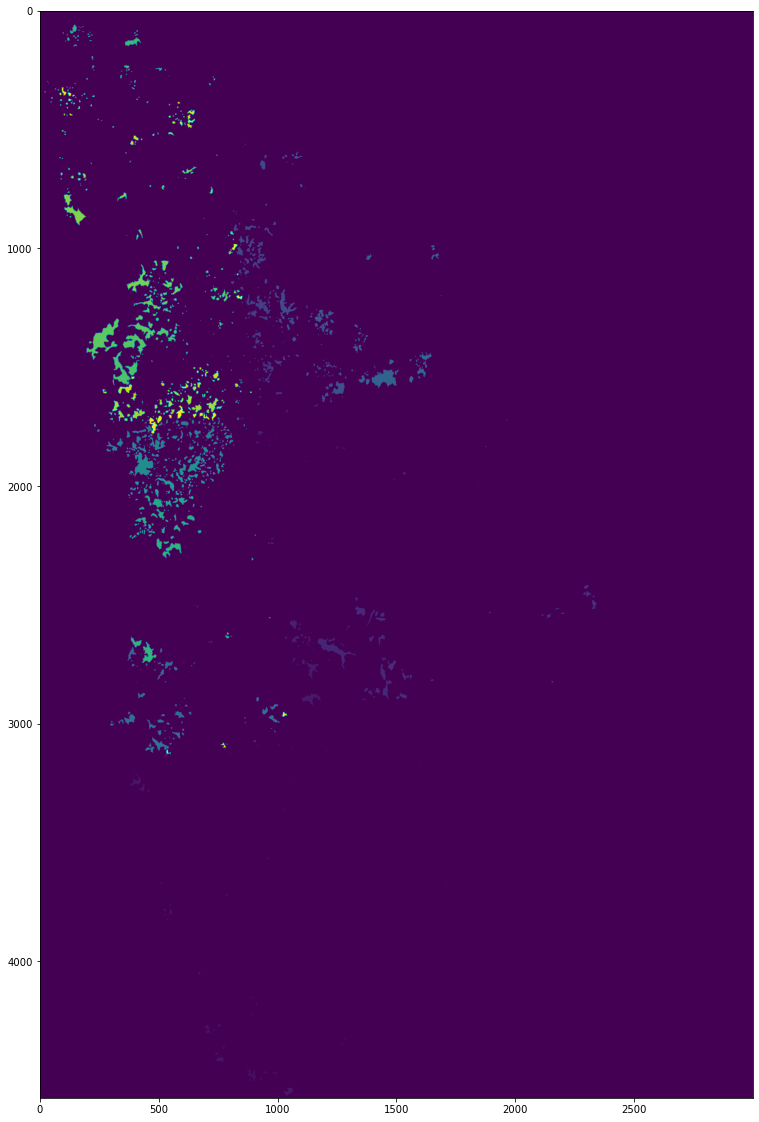

<AxesSubplot:>

In [18]:
figure(figsize=(20,20))
riop.show(test_img)

<AxesSubplot:>

<Figure size 1440x1440 with 0 Axes>

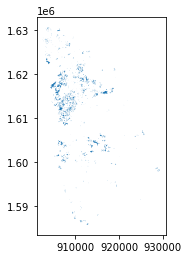

In [19]:
figure(figsize=(20,20))
huc_sinks.plot()

In [20]:
sinksfile = os.path.join(datadir,'test_rasterize.tif')
wat = calc_karst_fraction(datadir=datadir,
                          demfile='HUC-0511000106-elev_cm.tif',
                          sinksfile=sinksfile)

./whitebox_tools --run="MeanFilter" --input='/home/mcoving/github/sinkhole_analysis/HUC-0511000106-elev_cm.tif' --output='/home/mcoving/github/sinkhole_analysis/HUC-0511000106-elev_cm-smoothed.tif' --filterx=5 --filtery=5

****************************
* Welcome to MeanFilter    *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Creating integral images: 0%
Creating integral images: 1%
Creating integral images: 2%
Creating integral images: 3%
Creating integral images: 4%
Creating integral images: 5%
Creating integral images: 6%
Creating integral images: 7%
Creating integral images: 8%
Creating integral images: 9%
Creating integral images: 10%
Creating integral images: 11%
Creating integral images: 12%
Creating integral images: 13%
Creating integral images: 14%
Creating integral images: 15%
Creating integral images: 16%
Creating integral images: 17%
Creating integral images: 18%
Creating integral images: 19%
Creating integral images: 

<AxesSubplot:>

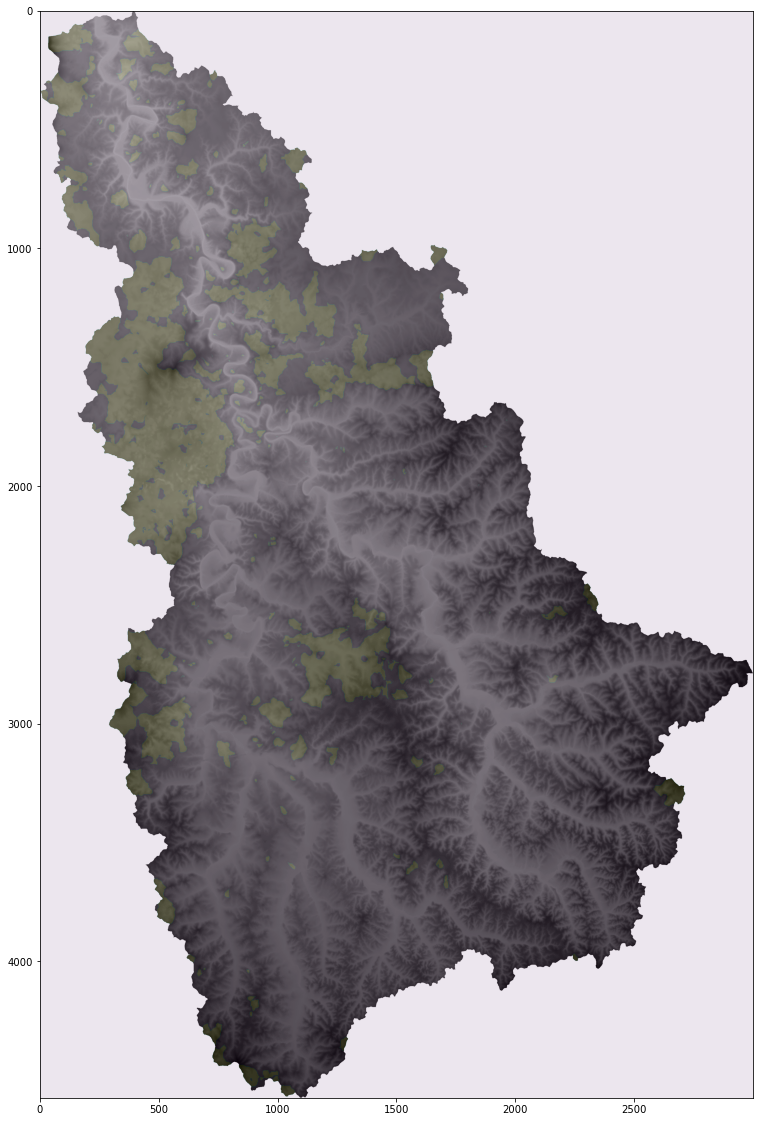

In [21]:
fig, ax = subplots(figsize=(20,20))
riop.show(img, ax=ax, cmap='Greys')
riop.show(wat, ax=ax, alpha=0.1)

In [4]:
sinksfile = os.path.join(datadir,'test_rasterize.tif')
wat = calc_karst_fraction(datadir=datadir,
                          demfile='HUC-0511000106-hydrodem.tif',
                          sinksfile=sinksfile,
                          fill_pits=False,
                          mean_filter=False)

./whitebox_tools --run="D8Pointer" --dem='/home/mcoving/github/sinkhole_analysis/HUC-0511000106-hydrodem-smoothed.tif' --output='/home/mcoving/github/sinkhole_analysis/HUC-0511000106-hydrodem-d8.tif'

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Prog

<AxesSubplot:>

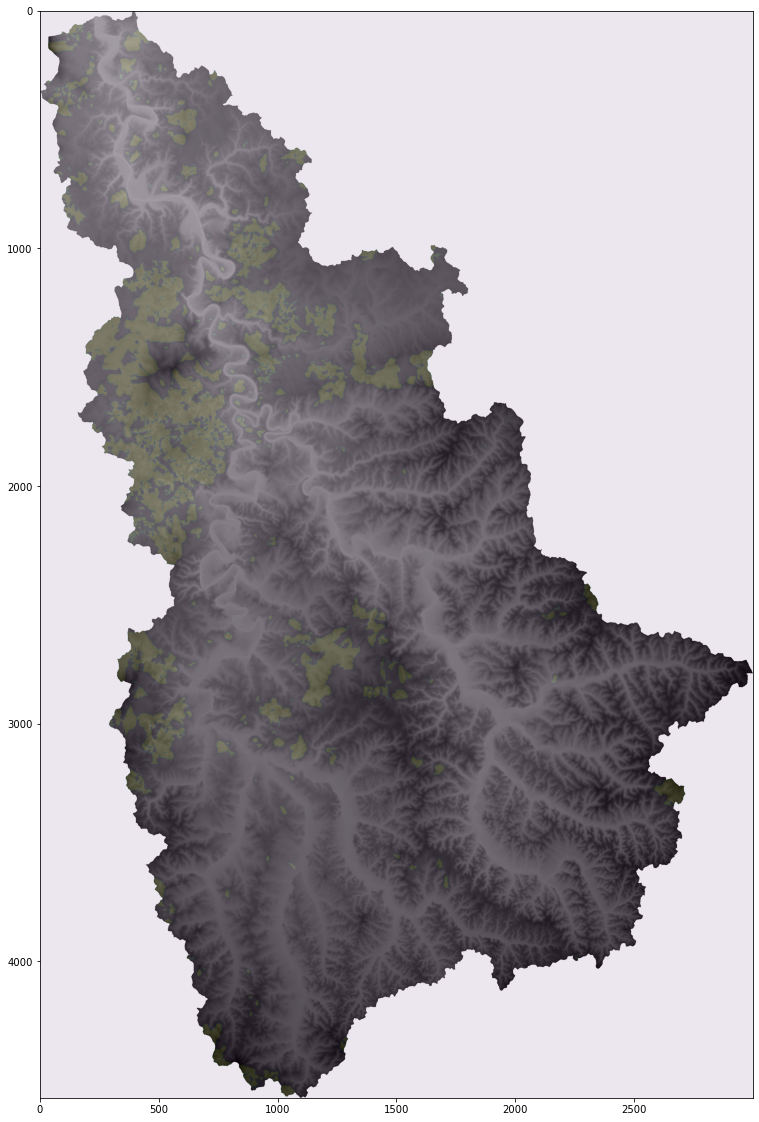

In [12]:
fig, ax = subplots(figsize=(20,20))
riop.show(img, ax=ax, cmap='Greys')
riop.show(wat, ax=ax, alpha=0.1)

In [11]:
from whitebox.whitebox_tools import WhiteboxTools
wbt = WhiteboxTools()


In [12]:
sinksfile = os.path.join(datadir,'test_rasterize.tif')

wbt.watershed(datadir+'HUC-0511000106-fdr.tif', sinksfile, datadir+'HUC051100016-fdr-wat.tif', esri_pntr=True)

./whitebox_tools --run="Watershed" --d8_pntr='/home/mcoving/github/sinkhole_analysis/HUC-0511000106-fdr.tif' --pour_pts='/home/mcoving/github/sinkhole_analysis/test_rasterize.tif' --output='/home/mcoving/github/sinkhole_analysis/HUC051100016-fdr-wat.tif' --esri_pntr

****************************
* Welcome to Watershed     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Initializing: 0%
Initializing: 1%
Initializing: 2%
Initializing: 3%
Initializing: 4%
Initializing: 5%
Initializing: 6%
Initializing: 7%
Initializing: 8%
Initializing: 9%
Initializing: 10%
Initializing: 11%
Initializing: 12%
Initializing: 13%
Initializing: 14%
Initializing: 15%
Initializing: 16%
Initializing: 17%
Initializing: 18%
Initializing: 19%
Initializing: 20%
Initializing: 21%
Initializing: 22%
Initializing: 23%
Initializing: 24%
Initializing: 25%
Initializing: 26%
Initializing: 27%
Initializing: 28%
Initializing: 29%
Initializing: 30%
Initializing: 31%
Initi

0

In [15]:
wat_src = rio.open(datadir+'HUC051100016-fdr-wat.tif')
wat = wat_src.read()
nkarst = len(wat[wat > 0])
nfluvial = len(wat[wat < 0])
print("n karst draining pixels =", nkarst)
print("n fluvial draining pixels =", nfluvial)
print("percent karst =", nkarst / (nkarst + nfluvial))

n karst draining pixels = 1155801
n fluvial draining pixels = 12561625
percent karst = 0.0842578629547555


<AxesSubplot:>

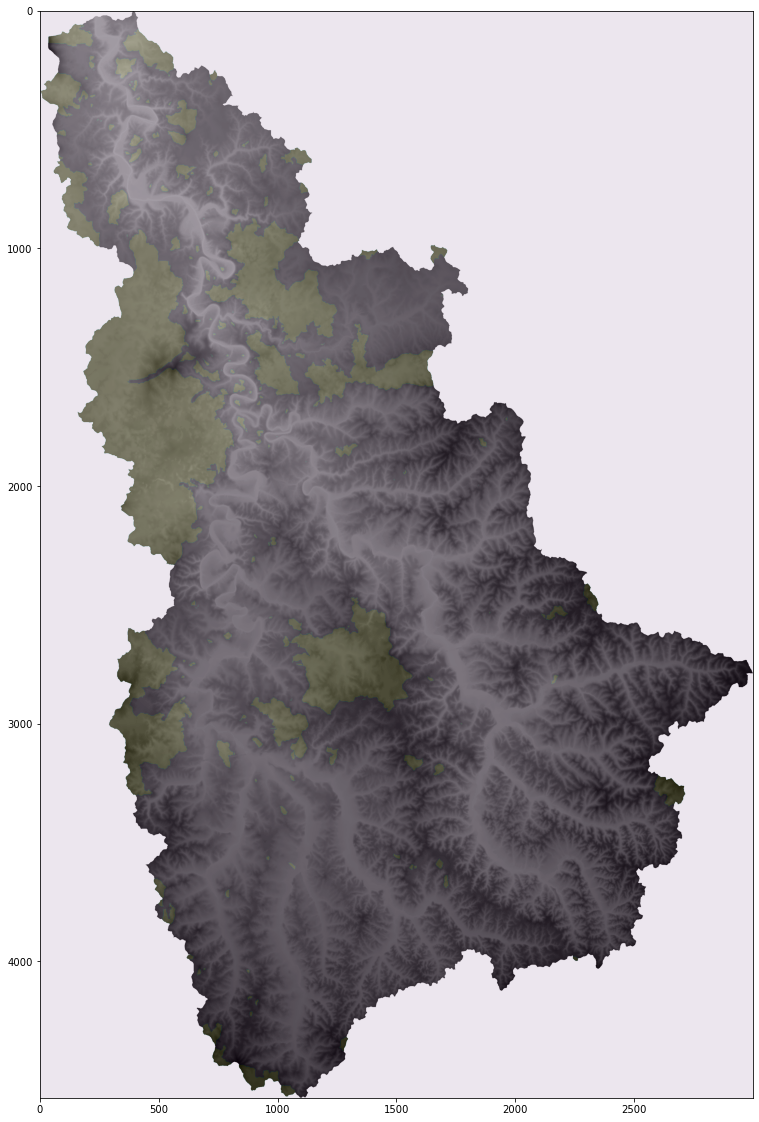

In [16]:
fig, ax = subplots(figsize=(20,20))
riop.show(img, ax=ax, cmap='Greys')
riop.show(wat, ax=ax, alpha=0.1)